# Stable Difussion Fine-tuning with Dreambooth








Imagine the scenario where we need to generate images that resemble a specific person's face, but that face is not included in the model's training data, we would rely on the model's ability to generalize from its learned representations. fine-tuning is a great approach for this scenario.

The model, after being trained on a diverse set of faces, should have grasped the underlying patterns and features common to human faces. A representation of a specific person's face, such as a sketch or a description, would be inputted, and the model would generate a new face that aligns with the input as closely as possible.

Fine-tuning is a technique used to train a custom model based on existing models, enabling the generation of custom images.

For example, personal photos can be added to the model, allowing it to generate unique images in various scenarios such as mountains, forests, streets, and so on.

## Methods of Fine Tuning

There are several methods to apply fine tuning:

1. **Additional Training**
   
  This involves training a base model with an additional dataset. For instance, you can train stable diffusion with an additional old car dataset to orient the aesthetics of the cars to that specific type.

2. **Dreambooth Algorithm**

  Initially developed by Google, this technique allows for injecting custom subjects into the models. Due to its architecture, it is possible to achieve great results using only 3 or 5 custom images.

![Dreambooth](https://storage.googleapis.com/rg-ai-bootcamp/stable-diffusion/dreambooth-high-level.png)

[Source](https://dreambooth.github.io/)

In this course, the focus is on using the Dreambooth algorithm for fine-tuning the Stable Diffusion model.

## Implementation

In the implementation, we'll use an image of a name in his 30s that we'll call John. This man was generated using Stable Diffusion to avoid copyright infringement. You can simply use a picture of yourself if you want to try things out.

![John](https://storage.googleapis.com/rg-ai-bootcamp/stable-diffusion/john.png)

### Installing the libraries

In [ ]:
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/examples/dreambooth/train_dreambooth.py
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/scripts/convert_diffusers_to_original_stable_diffusion.py
%pip install -qq git+https://github.com/ShivamShrirao/diffusers
%pip install -q -U --pre triton==2.1.0
%pip install -q accelerate transformers ftfy bitsandbytes gradio natsort safetensors xformers

### Loading the model


In [ ]:
model_sd = "runwayml/stable-diffusion-v1-5"
output_dir = "/content/stable_diffusion_weights/john"

In [ ]:
!mkdir -p $output_dir

### Training

Dreambooth training requires a unique identifier, the class name, and images of the subject to be inserted. The images form the dataset. The unique identifier needs to be a term associated with no concept or feature recognized by the model. The class is the type of object you want to generate.

Three components are needed:

1. **Unique Identifier**

  This is a unique name that does not exist in the model. In our case, we will use john.

2. **Class Name**

  This is the type of object that will be generated. In our case, we will generate faces of people.

3. **images**

  These are the training datasets. In our case, we have uploaded ten images.

Instance prompt
a photo of [unique identifier] [class name]

Class prompt
> a photo of [class name]

The instance prompt will be as follows:
> a photo of john person

As the subject is a person, the class prompt will be as follows:
> a photo of a person

In this demonstration, we'll be utilizing photos of John as basis to train the Stable Diffusion Model, aiming to generate images similar to John.

#### Creating the Instance and Class Prompts

We need to create a new variable concepts_list. It will be a list in Python. Then we need to specify the parameters.

In [ ]:
concepts_list = [
    {
        "instance_prompt": "john", #unique identifier
        "class_prompt": "photo of a person",
        "instance_data_dir": "/content/data/john",
        "class_data_dir": "/content/data/person"}
    # ,
    # {
    #     "instance_prompt": "dudung", #unique identifier
    #     "class_prompt": "photo of a person",
    #     "instance_data_dir": "/content/data/dudung",
    #     "class_data_dir": "/content/data/person"
    # },
    # {
    #     "instance_prompt": "neptune", #unique identifier
    #     "class_prompt": "image of a fish",
    #     "instance_data_dir": "/content/data/neptune",
    #     "class_data_dir": "/content/data/fish"
    # }
]

#### Creating Directories and JSON File

We need to create directories and convert this variable into a JSON file

In [ ]:
import json
import os
import random

for c in concepts_list:
  os.makedirs(c["instance_data_dir"], exist_ok=True)

In [ ]:
with open("concepts_list.json", "w") as f:
  json.dump(concepts_list, f, indent=4)

#### Upload Training Images

1. Ensure that images are of size 512 x 512. If they are not, need to resize them.
2. Use the file upload feature in the left sidebar.
3. Move the images to folder `/content/data/john`

#### Specifying Parameters

We need to specify some parameters before running the algorithm

In [ ]:
import os

len(os.listdir("/content/data/person"))

180

In [ ]:
num_imgs = 15 # banyak gambar
num_class_images = num_imgs * 12 # perlu liat di github link
max_num_steps = num_imgs * 100 # steps untuk training
learning_rate = 1e-6 # learning rate == 1x10^-6
lr_warmup_steps = int(max_num_steps / num_imgs) # step warmup learning rate, upaya supaya meningkatkan change sampai di global optimum

In [ ]:
print(num_imgs, num_class_images, max_num_steps, learning_rate, lr_warmup_steps)

15 180 1500 1e-06 100


The `learning_rate` is a hyperparameter that determines the step size at which an optimization algorithm (like gradient descent) proceeds while learning from the data. It controls how much to change the model in response to the estimated error each time the model weights are updated.

If the learning rate is too small, the model will need many updates to converge to the best values, which can take a long time. On the other hand, if the learning rate is too large, the updates may be too significant and the model may pass over the optimal solution, or even diverge.

---

`lr_warmup_steps` is a hyperparameter used in the learning rate scheduling strategy, specifically in the warmup phase of training.

Learning rate warmup is a strategy where the learning rate is initially set to a small value and gradually increased to the maximum or initial learning rate. This is done over a certain number of steps or epochs, which is what `lr_warmup_steps` refers to.

The purpose of this strategy is to prevent the model from overfitting early in the training process. By starting with a smaller learning rate, the model makes smaller adjustments and doesn't converge too quickly to a suboptimal solution. After the warmup steps, the learning rate is increased to allow the model to learn more quickly and converge to the optimal solution.

#### Execute Training

Finally, we can train the algorithm

In [ ]:
!python3 train_dreambooth.py \
  --pretrained_model_name_or_path=$model_sd \
  --pretrained_vae_name_or_path="stabilityai/sd-vae-ft-mse" \
  --instance_data_dir=$output_dir \
  --output_dir=$output_dir \
  --revision="fp16" \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --seed=777 \
  --resolution=512 \
  --train_batch_size=1 \
  --train_text_encoder \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --gradient_accumulation_steps=1 \
  --learning_rate=$learning_rate \
  --lr_scheduler="constant" \
  --lr_warmup_steps=$lr_warmup_steps \
  --num_class_images=$num_class_images \
  --sample_batch_size=4 \
  --max_train_steps=$max_num_steps \
  --save_interval=10000 \
  --save_sample_prompt="john" \
  --concepts_list="concepts_list.json"

2024-02-21 12:25:21.592329: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 12:25:21.592375: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 12:25:21.593809: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-21 12:25:22.918085: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you do

This process will take about 20 minutes to finish. If an error occurs during training, ensure that the images or datasets are in the correct folder. Once the training is complete, we can proceed to perform the first tests.

### Images and model weights are stored

The weights directory is a specific location in the file system where the weights of a trained machine learning model are stored.

These weights are the learned parameters that the model uses to make predictions or decisions.

They are typically saved so that the model can be reused later, either for further training, for fine-tuning on a different task, or for direct inference.

In [ ]:
## mengambil checkpoint/weight terakhir
from natsort import natsorted
from glob import glob
import os

weights_dir = natsorted(glob(output_dir + os.sep + '*'))[-1]
print('Weights directory: ', weights_dir)

Weights directory:  /content/stable_diffusion_weights/john/1500


In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# function to display images in grid
def grid_img(imgs, rows=1, cols=3, scale=1):
  assert len(imgs) == rows * cols

  w, h = imgs[0].size
  w, h = int(w*scale), int(h*scale)

  grid = Image.new('RGB', size=(cols*w, rows*h))
  grid_w, grid_h = grid.size

  for i, img in enumerate(imgs):
      img = img.resize((w,h), Image.ANTIALIAS)
      grid.paste(img, box=(i%cols*w, i//cols*h))
  return grid

<ipython-input-10-24d7c5675b23>:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((w,h), Image.ANTIALIAS)


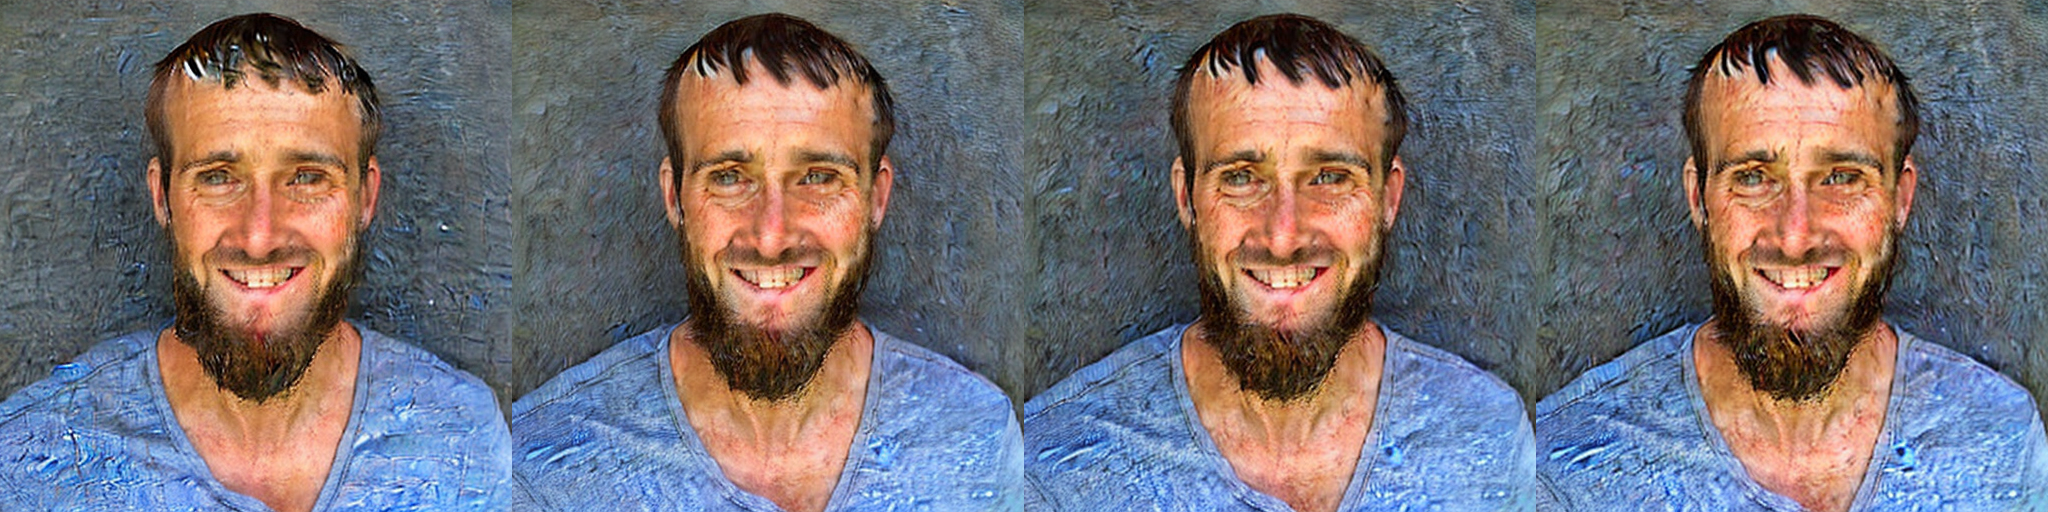

In [ ]:
weights_folder = output_dir
folders = sorted([f for f in os.listdir(weights_folder) if f != "0"], key = lambda x: int(x))

imgs_test = []

for imgs, folder in enumerate(folders):
  folder_path = os.path.join(weights_folder, folder)
  image_folder = os.path.join(folder_path, "samples")
  images = [f for f in os.listdir(image_folder)]

  for i in images:
    img_path = os.path.join(image_folder, i)
    r = Image.open(img_path)
    imgs_test.append(r)

# show images that generated after training
grid_img(imgs_test, rows=1, cols=4, scale=1)

## Convert the weights into (checkpoint)

Checkpoints are used to save and load the progress of training, allowing you to resume training from the exact point it was stopped.

Converting the weights into a checkpoint involves saving the current state of the model, including its learned weights, into a format that can be easily loaded later.

This process allows for the model's state to be preserved, so that the training process can be resumed later if needed, or the trained model can be used for generating images.

In [ ]:
ckpt_path = weights_dir + "/model.ckpt"

half_arg = "--half"

!python convert_diffusers_to_original_stable_diffusion.py --model_path $weights_dir  --checkpoint_path $ckpt_path $half_arg
print(f"Converted to ckpt and saved in {ckpt_path}")

Reshaping encoder.mid.attn_1.q.weight for SD format
Reshaping encoder.mid.attn_1.k.weight for SD format
Reshaping encoder.mid.attn_1.v.weight for SD format
Reshaping encoder.mid.attn_1.proj_out.weight for SD format
Reshaping decoder.mid.attn_1.q.weight for SD format
Reshaping decoder.mid.attn_1.k.weight for SD format
Reshaping decoder.mid.attn_1.v.weight for SD format
Reshaping decoder.mid.attn_1.proj_out.weight for SD format
Converted to ckpt and saved in /content/stable_diffusion_weights/john/1500/model.ckpt


## Inference / Generating images (tests the fine tune model)

In [ ]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler
from IPython.display import display

In [ ]:
model_path = weights_dir
print(model_path)

/content/stable_diffusion_weights/john/1500


In [ ]:
pipe = StableDiffusionPipeline.from_pretrained(model_path, torch_dtype=torch.float16).to('cuda')

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [ ]:
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.enable_xformers_memory_efficient_attention()

pipe.safety_checker = lambda images, clip_input: (images, False)

seed = 555

Seed: 123


  0%|          | 0/30 [00:00<?, ?it/s]

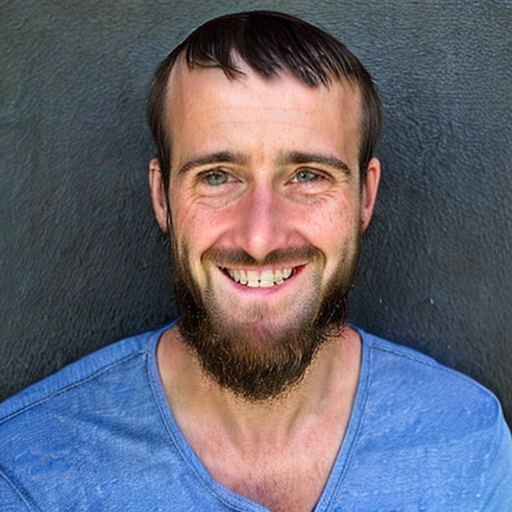

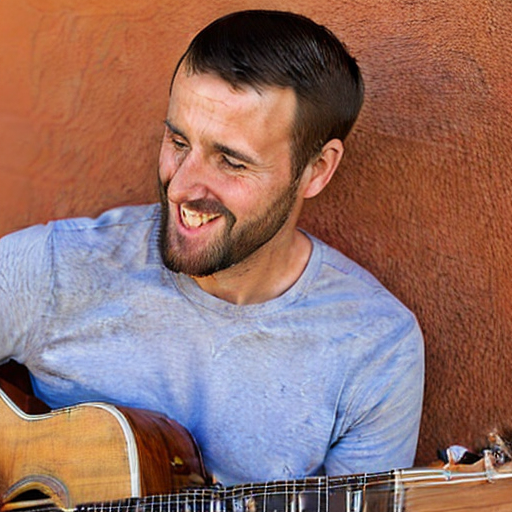

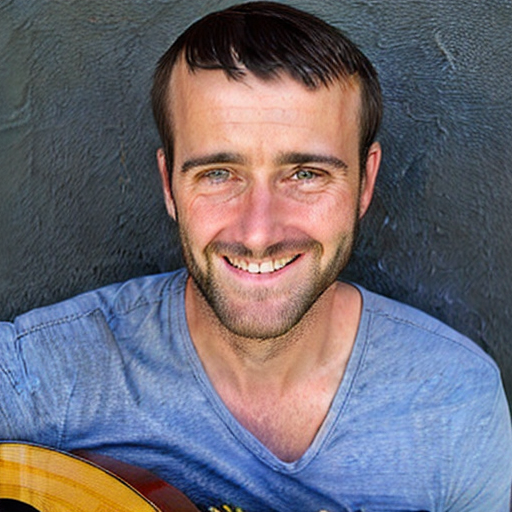

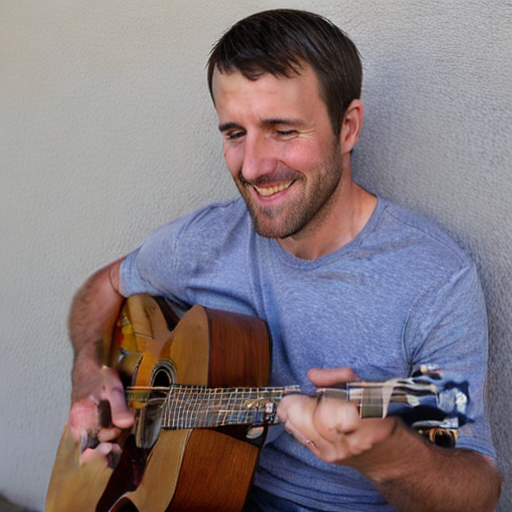

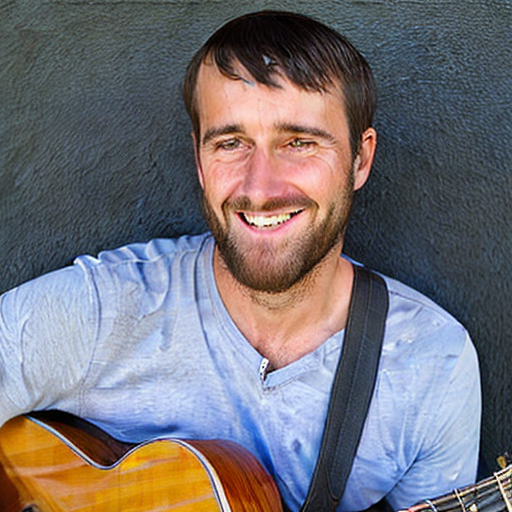

In [ ]:
prompt = "face portrait of john playing guitar in the restaurant, realistic, hd, vivid, sunset"
negative_prompt = "bad anatomy, ugly, deformed, desfigured, distorted face, poorly drawn hands, poorly drawn face, poorly drawn feet, blurry, low quality, low definition, lowres, out of frame, out of image, cropped, cut off, signature, watermark"
num_samples = 5
guidance_scale = 7.5
num_inference_steps = 30
height = 512
width = 512

seed = 123
print("Seed: {}".format(str(seed)))
generator = torch.Generator(device='cuda').manual_seed(seed)

with autocast("cuda"), torch.inference_mode():
    imgs = pipe(
        prompt,
        negative_prompt=negative_prompt,
        height=height, width=width,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=generator
    ).images

for img in imgs:
    display(img)

### Testing multiple prompts

Seed: 88


  0%|          | 0/75 [00:00<?, ?it/s]

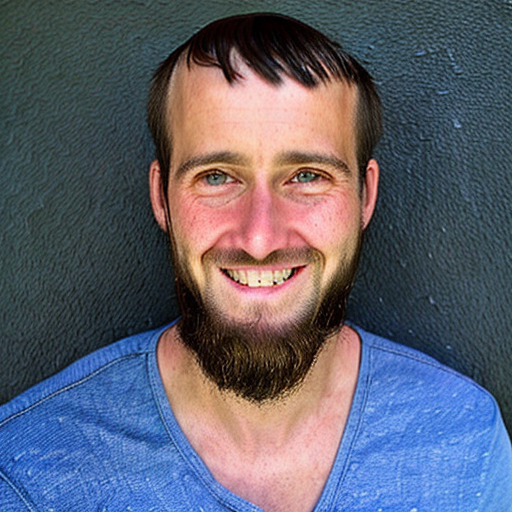

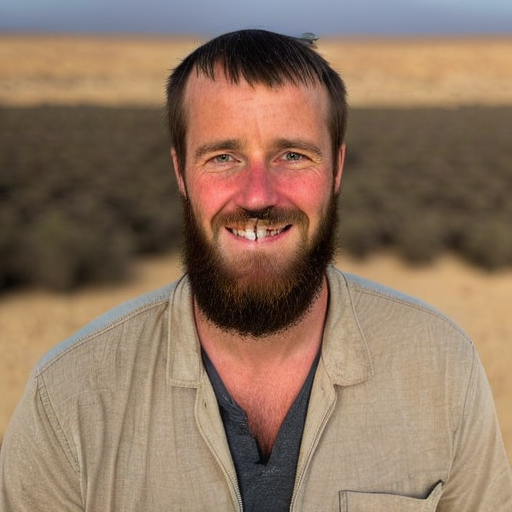

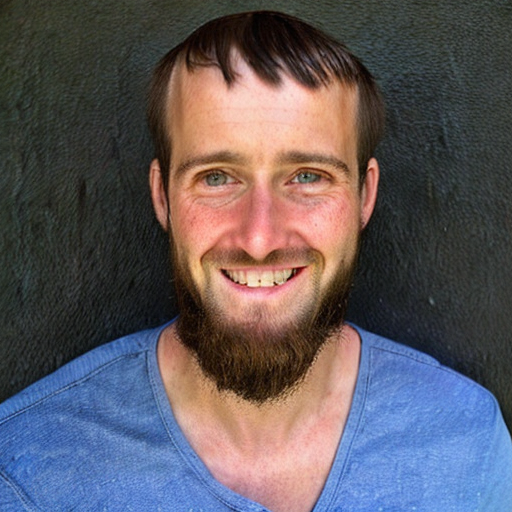

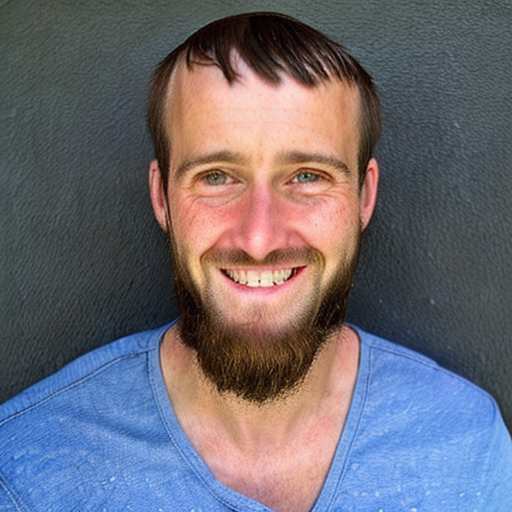

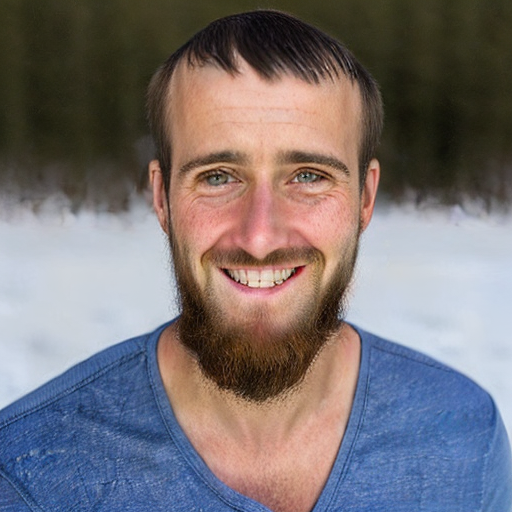

In [ ]:
prompt = ["photo of john person, closeup, mountain fuji in the background, natural lighting",
          "photo of john person in the desert, closeup, pyramids in the background, natural lighting, frontal face",
          "photo of john person in the forest, natural lighting, frontal face",
          "photo of john person as an astronaut, natural lighting, frontal face, closeup, starry sky in the background",
          "face portrait of john in the snow, realistic, hd, vivid, sunset"]

negative_prompt = ["bad anatomy, ugly, deformed, desfigured, distorted face, poorly drawn hands, poorly drawn face, poorly drawn feet, blurry, low quality, low definition, lowres, out of frame, out of image, cropped, cut off, signature, watermark" ] * len(prompt)
num_samples = 1
guidance_scale = 8
num_inference_steps = 75
height = 512
width = 512

seed = 88
print("Seed: {}".format(str(seed)))
generator = torch.Generator(device='cuda').manual_seed(seed)

with autocast("cuda"), torch.inference_mode():
    imgs = pipe(
        prompt,
        negative_prompt=negative_prompt,
        height=height, width=width,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=generator
    ).images

for img in imgs:
    display(img)

### More prompt examples

* in the forest, in cairo, in cairo desert,  in a western scene, in star wars, in mountain fuji, in the snow, etc.

> Other combinations:

* `photo of john person, closeup, mountain fuji in the background, natural lighting `

* `digital painting of john in the snow, realistic, hd, vivid, sunset`

* `watercolor painting of john person, realistic, blue and orange tones `

* `digital painting of john person, hyperrealistic, fantasy, Surrealist, painted by Alphonse Mucha`

* `painting of john person in star wars, realistic, 4k ultra hd, blue and red tones`

* `photo of john person, in an armor, realistic, visible face, colored, detailed face, ultra detailed, natural lighting`

* `photo of john person, cyberpunk, vivid, realistic, 4k ultra hd`

* `anime painting of john person, chill day, by tim okamura, noah bradley, trending on artstation  `

## Saving the results

In [ ]:
!mkdir results

In [ ]:
for i, img in enumerate(imgs):
  img.save('results/result_{}.png'.format(i+1))

## Exercise Fine Tuning

In [ ]:
# Installing Libs
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/examples/dreambooth/train_dreambooth.py
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/scripts/convert_diffusers_to_original_stable_diffusion.py
%pip install -qq git+https://github.com/ShivamShrirao/diffusers
%pip install -q -U --pre triton==2.1.0
%pip install -q accelerate transformers ftfy bitsandbytes gradio natsort safetensors xformers
%pip install rggrader

In [ ]:
# @title #### Student Identity
student_id = "your student id" # @param {type:"string"}
name = "your name" # @param {type:"string"}

In [ ]:
# @title #### 00. Fine-tuning with Dreambooth
from rggrader import submit_image
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler
from IPython.display import display
import os
import matplotlib.pyplot as plt
from PIL import Image
from natsort import natsorted
from glob import glob
import json
import random

# TODO:
# 1. Load Model: Load 'runwayml/stable-diffusion-v1-5'.
# 2. Prepare Images: use your photos to train the provided model.
# 3. Fine-Tune: Train the model on your dataset.
# 4. Generate Faces: Use the fine-tuned model to create new faces.
# 5. Save Results: Store the generated images in the 'results' folder.
# 6. Upload Image: Choose one image from 'results' and upload it for review.

# Note: Create folder '/content/data/input_image' to upload Training Image

# Loading model and create output dir
model_sd = "runwayml/stable-diffusion-v1-5"
output_dir = "/content/stable_diffusion_weights/student_data"
!mkdir -p $output_dir

# Put your code here:
imgs = None

# ---- End of your code ----

# Saving the results
!mkdir results
for i, img in enumerate(imgs):
    img.save('results/result_{}.png'.format(i+1))

In [ ]:
# Submit Method
assignment_id = "00_fine_tuning"
question_id = "00_fine_tuning_with_dreambooth"
submit_image(student_id, question_id, 'your_image.png') # change 'your_image.png' to the name of the image you want to upload (eg. results/result_3.png)

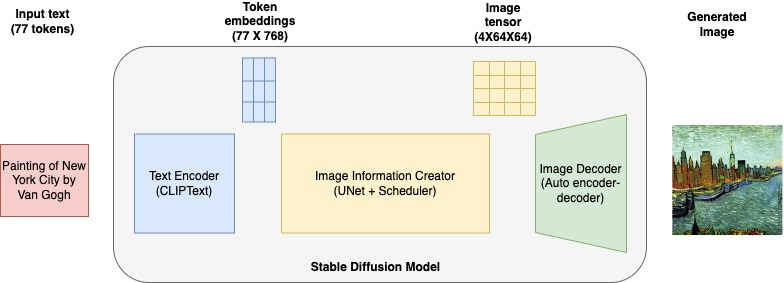

In [ ]:
#vae = variational autoencoder > encoding input